In [1]:
import xarray as xr
import pandas as pd

lightning = xr.open_dataset('lightning_july2024_hourly.nc')
print(lightning)

<xarray.Dataset> Size: 226MB
Dimensions:            (time: 713, latitude: 141, longitude: 281)
Coordinates:
  * time               (time) datetime64[ns] 6kB 2024-07-01 ... 2024-07-31T23...
  * latitude           (latitude) float32 564B 20.0 20.25 20.5 ... 54.75 55.0
  * longitude          (longitude) float32 1kB -130.0 -129.8 ... -60.25 -60.0
Data variables:
    lightning_density  (time, latitude, longitude) float32 113MB ...
    lightning_energy   (time, latitude, longitude) float32 113MB ...
Attributes: (12/17)
    title:                GLM Lightning Data - July 2024 - ERA5 Grid
    source:               GOES-16 GLM Level 3
    grid_resolution:      0.25 degrees (ERA5 standard)
    spatial_coverage:     USA Continental (-130°W to -60°W, 20°N to 55°N)
    temporal_resolution:  1 hour
    created:              2025-11-30T22:49:50.980285
    ...                   ...
    time_coverage_start:  2024-07-01T00:00:00.000000000
    time_coverage_end:    2024-07-31T23:00:00.000000000
    total

In [2]:
store1 = 'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3'

ds1 = xr.open_dataset(store1, engine='zarr', chunks={})[['convective_available_potential_energy',
                                                          'total_precipitation',
                                                          '2m_temperature',
                                                          'total_column_water_vapour',
                                                          'vertical_velocity']]
print(ds1)

<xarray.Dataset> Size: 225TB
Dimensions:                                (time: 1323648, latitude: 721,
                                            longitude: 1440, level: 37)
Coordinates:
  * time                                   (time) datetime64[ns] 11MB 1900-01...
  * latitude                               (latitude) float32 3kB 90.0 ... -90.0
  * longitude                              (longitude) float32 6kB 0.0 ... 359.8
  * level                                  (level) int64 296B 1 2 3 ... 975 1000
Data variables:
    convective_available_potential_energy  (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    total_precipitation                    (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    2m_temperature                         (time, latitude, longitude) float32 5TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    total_column_water_vapour              (time, latitude, l

In [3]:
# July 2024
time_start = '2024-07-01'
time_end = '2024-07-31T23:00:00'

# Tu área (en formato 0-360)
lat_min, lat_max = 20, 55
lon_min, lon_max = 230, 300  # equivale a -130 to -60

# Filtrar
ds_july = ds1.sel(
    time=slice(time_start, time_end),
    latitude=slice(lat_max, lat_min),  # ERA5 va de 90 a -90
    longitude=slice(lon_min, lon_max)
)

print(ds_july)

<xarray.Dataset> Size: 5GB
Dimensions:                                (time: 744, latitude: 141,
                                            longitude: 281, level: 37)
Coordinates:
  * time                                   (time) datetime64[ns] 6kB 2024-07-...
  * latitude                               (latitude) float32 564B 55.0 ... 20.0
  * longitude                              (longitude) float32 1kB 230.0 ... ...
  * level                                  (level) int64 296B 1 2 3 ... 975 1000
Data variables:
    convective_available_potential_energy  (time, latitude, longitude) float32 118MB dask.array<chunksize=(1, 141, 281), meta=np.ndarray>
    total_precipitation                    (time, latitude, longitude) float32 118MB dask.array<chunksize=(1, 141, 281), meta=np.ndarray>
    2m_temperature                         (time, latitude, longitude) float32 118MB dask.array<chunksize=(1, 141, 281), meta=np.ndarray>
    total_column_water_vapour              (time, latitude, longi

In [4]:
# Seleccionar solo 500 hPa para vertical velocity
ds_era5 = ds_july.sel(level=500)
print(ds_era5)

<xarray.Dataset> Size: 590MB
Dimensions:                                (time: 744, latitude: 141,
                                            longitude: 281)
Coordinates:
  * time                                   (time) datetime64[ns] 6kB 2024-07-...
  * latitude                               (latitude) float32 564B 55.0 ... 20.0
  * longitude                              (longitude) float32 1kB 230.0 ... ...
    level                                  int64 8B 500
Data variables:
    convective_available_potential_energy  (time, latitude, longitude) float32 118MB dask.array<chunksize=(1, 141, 281), meta=np.ndarray>
    total_precipitation                    (time, latitude, longitude) float32 118MB dask.array<chunksize=(1, 141, 281), meta=np.ndarray>
    2m_temperature                         (time, latitude, longitude) float32 118MB dask.array<chunksize=(1, 141, 281), meta=np.ndarray>
    total_column_water_vapour              (time, latitude, longitude) float32 118MB dask.array<chu

In [5]:
# Load lightning data
lightning = xr.open_dataset('lightning_july2024_hourly.nc')

# Problem: different longitude formats
# ERA5: 230 to 300
# Lightning: -130 to -60

# Convert ERA5 to -180 to 180 format
ds_era5_aligned = ds_era5.assign_coords(
    longitude=(ds_era5.longitude - 360).values
)

print("ERA5 lon:", ds_era5_aligned.longitude.values[:3], "...", ds_era5_aligned.longitude.values[-3:])
print("Lightning lon:", lightning.longitude.values[:3], "...", lightning.longitude.values[-3:])

ERA5 lon: [-130.   -129.75 -129.5 ] ... [-60.5  -60.25 -60.  ]
Lightning lon: [-130.   -129.75 -129.5 ] ... [-60.5  -60.25 -60.  ]


In [6]:
# Find common times between both datasets
common_times = pd.DatetimeIndex(
    set(ds_era5_aligned.time.values) & set(lightning.time.values)
)
common_times = common_times.sort_values()

print(f"ERA5 times: {len(ds_era5_aligned.time)}")
print(f"Lightning times: {len(lightning.time)}")
print(f"Common times: {len(common_times)}")
# Select only common times
era5_final = ds_era5_aligned.sel(time=common_times)
lightning_final = lightning.sel(time=common_times)

print(f"ERA5 final shape: {era5_final.dims}")
print(f"Lightning final shape: {lightning_final.dims}")

ERA5 times: 744
Lightning times: 713
Common times: 713
ERA5 final shape: FrozenMappingWarningOnValuesAccess({'time': 713, 'latitude': 141, 'longitude': 281})
Lightning final shape: FrozenMappingWarningOnValuesAccess({'time': 713, 'latitude': 141, 'longitude': 281})


In [7]:
# Merge ERA5 and lightning
ds_merged = xr.merge([era5_final, lightning_final])

print(ds_merged)

<xarray.Dataset> Size: 791MB
Dimensions:                                (latitude: 141, time: 713,
                                            longitude: 281)
Coordinates:
  * latitude                               (latitude) float32 564B 20.0 ... 55.0
  * time                                   (time) datetime64[ns] 6kB 2024-07-...
  * longitude                              (longitude) float32 1kB -130.0 ......
    level                                  int64 8B 500
Data variables:
    convective_available_potential_energy  (time, latitude, longitude) float32 113MB dask.array<chunksize=(1, 141, 281), meta=np.ndarray>
    total_precipitation                    (time, latitude, longitude) float32 113MB dask.array<chunksize=(1, 141, 281), meta=np.ndarray>
    2m_temperature                         (time, latitude, longitude) float32 113MB dask.array<chunksize=(1, 141, 281), meta=np.ndarray>
    total_column_water_vapour              (time, latitude, longitude) float32 113MB dask.array<chu

/tmp/ipykernel_229/350498694.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'latitude' ('latitude',) The recommendation is to set join explicitly for this case.
  ds_merged = xr.merge([era5_final, lightning_final])


In [8]:
# Check first and last times match
print("ERA5 first:", era5_final.time.values[0])
print("Lightning first:", lightning_final.time.values[0])
print()
print("ERA5 last:", era5_final.time.values[-1])
print("Lightning last:", lightning_final.time.values[-1])

ERA5 first: 2024-07-01T00:00:00.000000000
Lightning first: 2024-07-01T00:00:00.000000000

ERA5 last: 2024-07-31T23:00:00.000000000
Lightning last: 2024-07-31T23:00:00.000000000


In [9]:
# Convert to DataFrame
# This takes a few minutes - loading all data

print("Loading data... (this may take a few minutes)")

df = ds_merged.to_dataframe().reset_index()

print(f"Shape: {df.shape}")
print(df.head())


Loading data... (this may take a few minutes)
Shape: (28249773, 11)
   latitude       time  longitude  convective_available_potential_energy  \
0      20.0 2024-07-01    -130.00                               5.692383   
1      20.0 2024-07-01    -129.75                               3.967285   
2      20.0 2024-07-01    -129.50                               2.415039   
3      20.0 2024-07-01    -129.25                               0.172363   
4      20.0 2024-07-01    -129.00                               0.172363   

   total_precipitation  2m_temperature  total_column_water_vapour  \
0             0.000024      296.155792                  23.298855   
1             0.000003      296.212830                  23.045256   
2             0.000013      296.189667                  23.018782   
3             0.000013      296.173615                  22.890587   
4             0.000000      296.137939                  22.843212   

   vertical_velocity  level  lightning_density  lightning_en

In [10]:
# Check for missing values
print(df.isnull().sum())

latitude                                   0
time                                       0
longitude                                  0
convective_available_potential_energy      0
total_precipitation                        0
2m_temperature                             0
total_column_water_vapour                  0
vertical_velocity                          0
level                                      0
lightning_density                          0
lightning_energy                         406
dtype: int64


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# =============================================================
# 5. SAMPLE - 3 million rows (won't crash)
# =============================================================
df_sample = df.sample(n=3_000_000, random_state=42)
print(f"Sample shape: {df_sample.shape}")

# =============================================================
# 6. Prepare features
# =============================================================
features = ['convective_available_potential_energy',
            'total_precipitation',
            '2m_temperature',
            'total_column_water_vapour',
            'vertical_velocity']

X = df_sample[features]
Y = (df_sample['lightning_density'] > 0).astype(int)

print(f"No lightning: {(Y == 0).sum():,}")
print(f"Lightning: {(Y == 1).sum():,}")

# =============================================================
# 7. Split: 70/15/15
# =============================================================
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.176, random_state=42)

print(f"\nTrain: {len(X_train):,}")
print(f"Validation: {len(X_val):,}")
print(f"Test: {len(X_test):,}")

# =============================================================
# 8. Train
# =============================================================
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("\nTraining... (5-10 min)")
rf.fit(X_train, Y_train)
print("Done!")

Sample shape: (3000000, 11)
No lightning: 2,972,344
Lightning: 27,656

Train: 2,101,200
Validation: 448,800
Test: 450,000

Training... (5-10 min)
Done!


=== VALIDATION RESULTS ===
Accuracy: 0.800
              precision    recall  f1-score   support

No Lightning       0.99      0.80      0.89    444674
   Lightning       0.02      0.54      0.05      4126

    accuracy                           0.80    448800
   macro avg       0.51      0.67      0.47    448800
weighted avg       0.99      0.80      0.88    448800


=== TEST RESULTS ===
Accuracy: 0.800
              precision    recall  f1-score   support

No Lightning       0.99      0.80      0.89    445797
   Lightning       0.02      0.53      0.05      4203

    accuracy                           0.80    450000
   macro avg       0.51      0.67      0.47    450000
weighted avg       0.99      0.80      0.88    450000



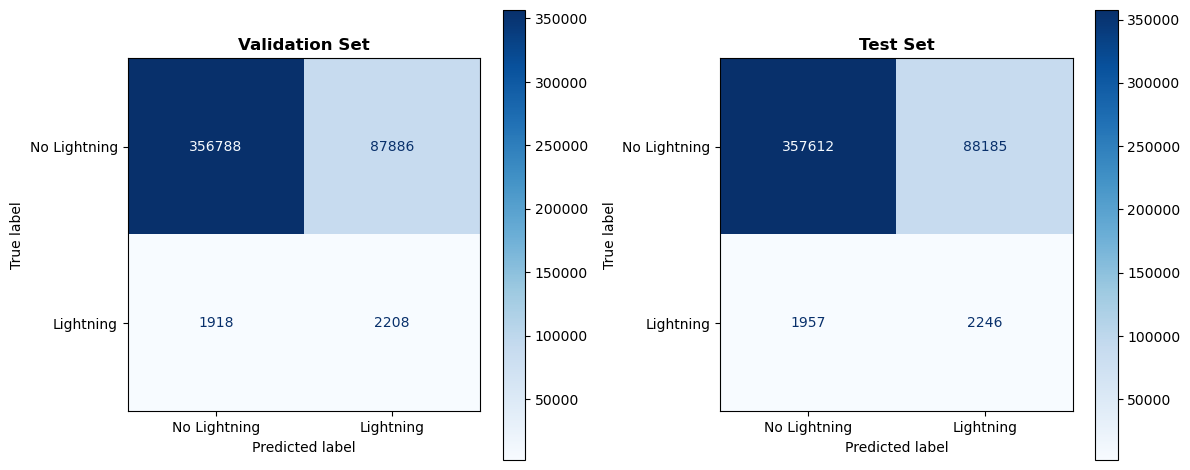

                                 Feature  Importance
3              total_column_water_vapour    0.296763
2                         2m_temperature    0.255259
0  convective_available_potential_energy    0.170874
4                      vertical_velocity    0.157706
1                    total_precipitation    0.119398


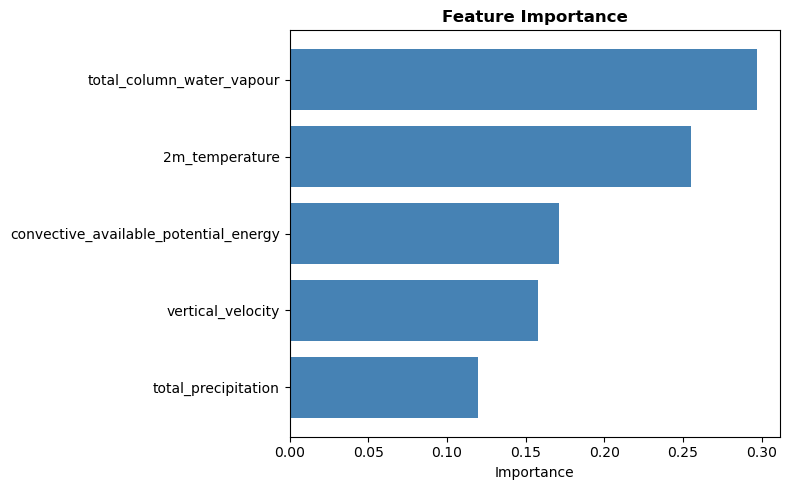

In [13]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Predictions on validation set
Y_val_pred = rf.predict(X_val)

# Predictions on test set
Y_test_pred = rf.predict(X_test)

# Validation metrics
print("=== VALIDATION RESULTS ===")
print(f"Accuracy: {accuracy_score(Y_val, Y_val_pred):.3f}")
print(classification_report(Y_val, Y_val_pred, target_names=['No Lightning', 'Lightning']))

# Test metrics
print("\n=== TEST RESULTS ===")
print(f"Accuracy: {accuracy_score(Y_test, Y_test_pred):.3f}")
print(classification_report(Y_test, Y_test_pred, target_names=['No Lightning', 'Lightning'])) 

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(Y_val, Y_val_pred, display_labels=['No Lightning', 'Lightning'], cmap='Blues', ax=axes[0])
axes[0].set_title('Validation Set', fontweight='bold')

ConfusionMatrixDisplay.from_predictions(Y_test, Y_test_pred, display_labels=['No Lightning', 'Lightning'], cmap='Blues', ax=axes[1])
axes[1].set_title('Test Set', fontweight='bold')

plt.tight_layout()
plt.show()
import pandas as pd

importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print(importance)

fig, ax = plt.subplots(figsize=(8, 5))
ax.barh(importance['Feature'], importance['Importance'], color='steelblue')
ax.set_xlabel('Importance')
ax.set_title('Feature Importance', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

Training with different n_trees...
  n_trees=10: val_recall=0.541, test_recall=0.540
  n_trees=25: val_recall=0.535, test_recall=0.530
  n_trees=50: val_recall=0.534, test_recall=0.531
  n_trees=75: val_recall=0.536, test_recall=0.536
  n_trees=100: val_recall=0.535, test_recall=0.534
  n_trees=150: val_recall=0.531, test_recall=0.534
  n_trees=200: val_recall=0.532, test_recall=0.536


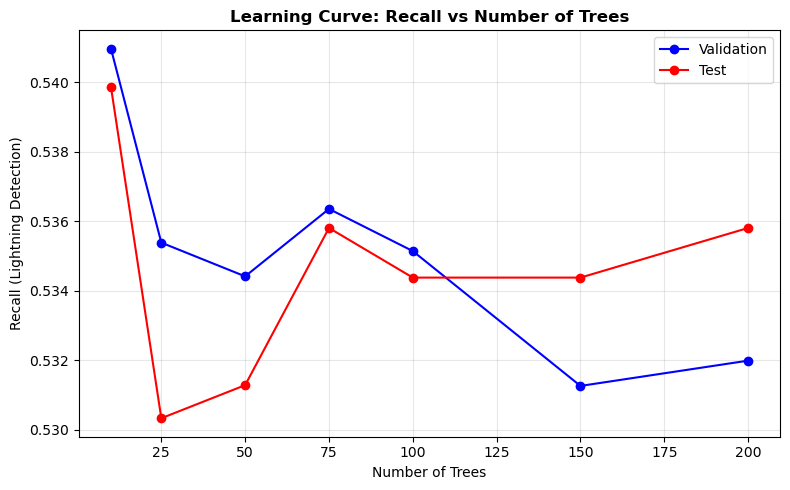

In [14]:
from sklearn.metrics import recall_score
import numpy as np

# Test different number of trees
n_trees_list = [10, 25, 50, 75, 100, 150, 200]
val_recalls = []
test_recalls = []

print("Training with different n_trees...")
for n_trees in n_trees_list:
    rf_temp = RandomForestClassifier(
        n_estimators=n_trees,
        max_depth=15,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf_temp.fit(X_train, Y_train)
    
    val_pred = rf_temp.predict(X_val)
    test_pred = rf_temp.predict(X_test)
    
    val_recalls.append(recall_score(Y_val, val_pred))
    test_recalls.append(recall_score(Y_test, test_pred))
    print(f"  n_trees={n_trees}: val_recall={val_recalls[-1]:.3f}, test_recall={test_recalls[-1]:.3f}")

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(n_trees_list, val_recalls, 'b-o', label='Validation')
ax.plot(n_trees_list, test_recalls, 'r-o', label='Test')
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Recall (Lightning Detection)')
ax.set_title('Learning Curve: Recall vs Number of Trees', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [15]:
# Save merged dataset
print("Saving...")
ds_merged.to_netcdf('lightning_era5_merged_july2024.nc')
print("Done!")

Saving...
Done!


In [16]:
# =============================================================
# COMPLETE STATISTICS: Classification + Regression
# =============================================================

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, mean_squared_error, 
                             mean_absolute_error, r2_score)
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# =============================================================
# 1. CLASSIFICATION METRICS
# =============================================================
print("=== CLASSIFICATION METRICS ===")
print(f"Accuracy:              {accuracy_score(Y_test, Y_test_pred):.4f}")
print(f"Precision (Lightning): {precision_score(Y_test, Y_test_pred):.4f}")
print(f"Recall (Lightning):    {recall_score(Y_test, Y_test_pred):.4f}")
print(f"F1-Score (Lightning):  {f1_score(Y_test, Y_test_pred):.4f}")
print(f"ROC-AUC:               {roc_auc_score(Y_test, rf.predict_proba(X_test)[:, 1]):.4f}")

# =============================================================
# 2. REGRESSION MODEL
# =============================================================
print("\nTraining regression model...")

Y_reg = df_sample['lightning_density']
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(
    X, Y_reg, test_size=0.2, random_state=42
)

rf_reg = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_reg.fit(X_train_reg, Y_train_reg)
Y_pred_reg = rf_reg.predict(X_test_reg)

print("\n=== REGRESSION METRICS ===")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_test_reg, Y_pred_reg)):.4f}")
print(f"MAE:  {mean_absolute_error(Y_test_reg, Y_pred_reg):.4f}")
print(f"R²:   {r2_score(Y_test_reg, Y_pred_reg):.4f}")

=== CLASSIFICATION METRICS ===
Accuracy:              0.7997
Precision (Lightning): 0.0248
Recall (Lightning):    0.5344
F1-Score (Lightning):  0.0475
ROC-AUC:               0.7462

Training regression model...

=== REGRESSION METRICS ===
RMSE: 77.4037
MAE:  4.9771
R²:   -0.0520


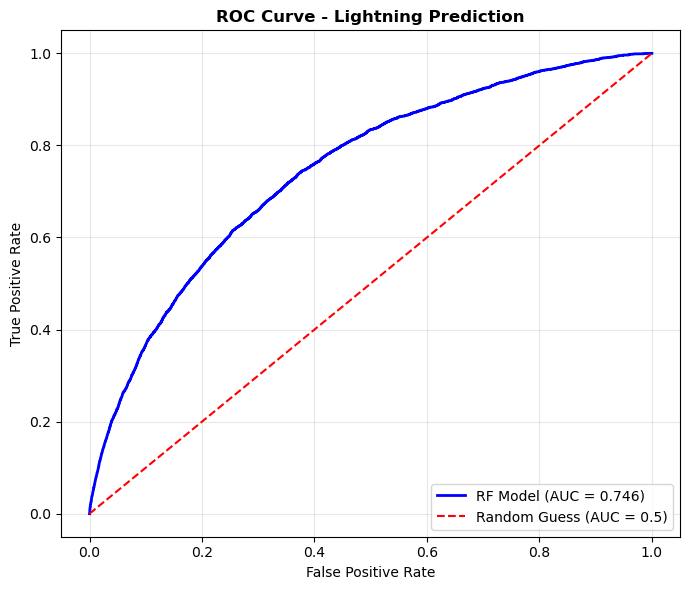

In [17]:
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots(figsize=(7, 6))

fpr, tpr, _ = roc_curve(Y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'RF Model (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], 'r--', label='Random Guess (AUC = 0.5)')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - Lightning Prediction', fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
# Sort by location and time
df_sorted = df.sort_values(['latitude', 'longitude', 'time']).copy()

# Shift lightning 1 hour forward
df_sorted['lightning_1h'] = df_sorted.groupby(['latitude', 'longitude'])['lightning_density'].shift(-1)

# Drop rows without future data
df_forecast = df_sorted.dropna(subset=['lightning_1h'])

print(f"Original rows: {len(df):,}")
print(f"Forecast rows: {len(df_forecast):,}")

Original rows: 28,249,773
Forecast rows: 28,210,152


In [19]:
# Sample 3 million
df_forecast_sample = df_forecast.sample(n=3_000_000, random_state=42)

# Features (current ERA5)
X_forecast = df_forecast_sample[features]

# Target (lightning 1 hour later, binary)
Y_forecast = (df_forecast_sample['lightning_1h'] > 0).astype(int)

print(f"No lightning (1h ahead): {(Y_forecast == 0).sum():,}")
print(f"Lightning (1h ahead): {(Y_forecast == 1).sum():,}")

# Split
X_train_f, X_test_f, Y_train_f, Y_test_f = train_test_split(
    X_forecast, Y_forecast, test_size=0.2, random_state=42
)

print(f"\nTrain: {len(X_train_f):,}")
print(f"Test: {len(X_test_f):,}")

No lightning (1h ahead): 2,972,562
Lightning (1h ahead): 27,438

Train: 2,400,000
Test: 600,000


In [20]:
# Train forecast model
rf_forecast = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

print("Training forecast model... (5-10 min)")
rf_forecast.fit(X_train_f, Y_train_f)
print("Done!")

# Predictions
Y_pred_f = rf_forecast.predict(X_test_f)

# Metrics
from sklearn.metrics import classification_report, recall_score, roc_auc_score

print("\n=== FORECAST RESULTS (1 hour ahead) ===")
print(f"Recall:  {recall_score(Y_test_f, Y_pred_f):.4f}")
print(f"ROC-AUC: {roc_auc_score(Y_test_f, rf_forecast.predict_proba(X_test_f)[:, 1]):.4f}")

print("\n" + classification_report(Y_test_f, Y_pred_f, target_names=['No Lightning', 'Lightning']))

Training forecast model... (5-10 min)
Done!

=== FORECAST RESULTS (1 hour ahead) ===
Recall:  0.5474
ROC-AUC: 0.7534

              precision    recall  f1-score   support

No Lightning       0.99      0.81      0.89    594498
   Lightning       0.03      0.55      0.05      5502

    accuracy                           0.80    600000
   macro avg       0.51      0.68      0.47    600000
weighted avg       0.99      0.80      0.88    600000



In [21]:
# Comparison table
print("="*50)
print("MODEL COMPARISON")
print("="*50)
print(f"{'Model':<20} {'ROC-AUC':<10} {'Recall':<10}")
print("-"*50)
print(f"{'Same time (T→T)':<20} {0.7462:<10.3f} {0.5344:<10.3f}")
print(f"{'Forecast (T→T+1)':<20} {roc_auc_score(Y_test_f, rf_forecast.predict_proba(X_test_f)[:, 1]):<10.3f} {recall_score(Y_test_f, Y_pred_f):<10.3f}")

MODEL COMPARISON
Model                ROC-AUC    Recall    
--------------------------------------------------
Same time (T→T)      0.746      0.534     
Forecast (T→T+1)     0.753      0.547     


In [22]:
# Try multiple lags
lags = [1, 2, 3]
results = []

for lag in lags:
    print(f"\nTraining lag={lag}h...")
    
    df_sorted[f'lightning_{lag}h'] = df_sorted.groupby(['latitude', 'longitude'])['lightning_density'].shift(-lag)
    df_lag = df_sorted.dropna(subset=[f'lightning_{lag}h']).sample(n=2_000_000, random_state=42)
    
    X_lag = df_lag[features]
    Y_lag = (df_lag[f'lightning_{lag}h'] > 0).astype(int)
    
    X_tr, X_te, Y_tr, Y_te = train_test_split(X_lag, Y_lag, test_size=0.2, random_state=42)
    
    rf_lag = RandomForestClassifier(n_estimators=100, max_depth=15, class_weight='balanced', random_state=42, n_jobs=-1)
    rf_lag.fit(X_tr, Y_tr)
    
    auc = roc_auc_score(Y_te, rf_lag.predict_proba(X_te)[:, 1])
    rec = recall_score(Y_te, rf_lag.predict(X_te))
    results.append({'Lag': f'{lag}h', 'ROC-AUC': auc, 'Recall': rec})
    print(f"  ROC-AUC: {auc:.3f}, Recall: {rec:.3f}")

# Plot
results_df = pd.DataFrame(results)
print("\n" + "="*40)
print(results_df.to_string(index=False))


Training lag=1h...
  ROC-AUC: 0.740, Recall: 0.507

Training lag=2h...
  ROC-AUC: 0.738, Recall: 0.511

Training lag=3h...
  ROC-AUC: 0.749, Recall: 0.526

Lag  ROC-AUC   Recall
 1h 0.739828 0.506835
 2h 0.738188 0.510558
 3h 0.749253 0.525549


In [23]:
# Try lags 4, 5, 6 hours
lags = [4, 5, 6]

for lag in lags:
    print(f"\nTraining lag={lag}h...")
    
    df_sorted[f'lightning_{lag}h'] = df_sorted.groupby(['latitude', 'longitude'])['lightning_density'].shift(-lag)
    df_lag = df_sorted.dropna(subset=[f'lightning_{lag}h']).sample(n=2_000_000, random_state=42)
    
    X_lag = df_lag[features]
    Y_lag = (df_lag[f'lightning_{lag}h'] > 0).astype(int)
    
    X_tr, X_te, Y_tr, Y_te = train_test_split(X_lag, Y_lag, test_size=0.2, random_state=42)
    
    rf_lag = RandomForestClassifier(n_estimators=100, max_depth=15, class_weight='balanced', random_state=42, n_jobs=-1)
    rf_lag.fit(X_tr, Y_tr)
    
    auc = roc_auc_score(Y_te, rf_lag.predict_proba(X_te)[:, 1])
    rec = recall_score(Y_te, rf_lag.predict(X_te))
    print(f"  ROC-AUC: {auc:.3f}, Recall: {rec:.3f}")


Training lag=4h...
  ROC-AUC: 0.746, Recall: 0.515

Training lag=5h...
  ROC-AUC: 0.750, Recall: 0.538

Training lag=6h...
  ROC-AUC: 0.751, Recall: 0.525


In [24]:
# Test different class weights
weights_options = [
    None,                    # Default (no balancing)
    'balanced',              # Auto balance
    {0: 1, 1: 50},          # Custom: lightning 50x more important
    {0: 1, 1: 100},         # Custom: lightning 100x more important
]

print("Testing different class weights...\n")

for weight in weights_options:
    rf_test = RandomForestClassifier(
        n_estimators=50,  # fewer trees for speed
        max_depth=15,
        class_weight=weight,
        random_state=42,
        n_jobs=-1
    )
    rf_test.fit(X_train_f, Y_train_f)
    
    Y_pred_test = rf_test.predict(X_test_f)
    
    prec = precision_score(Y_test_f, Y_pred_test)
    rec = recall_score(Y_test_f, Y_pred_test)
    auc = roc_auc_score(Y_test_f, rf_test.predict_proba(X_test_f)[:, 1])
    
    print(f"class_weight={str(weight):<20} | Precision: {prec:.3f} | Recall: {rec:.3f} | AUC: {auc:.3f}")

Testing different class weights...



/srv/conda/envs/notebook/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


class_weight=None                 | Precision: 0.000 | Recall: 0.000 | AUC: 0.747
class_weight=balanced             | Precision: 0.025 | Recall: 0.546 | AUC: 0.753
class_weight={0: 1, 1: 50}        | Precision: 0.043 | Recall: 0.264 | AUC: 0.756
class_weight={0: 1, 1: 100}       | Precision: 0.026 | Recall: 0.517 | AUC: 0.752


Libraries loaded!

Loading data...
<xarray.Dataset> Size: 791MB
Dimensions:                                (time: 713, latitude: 141,
                                            longitude: 281)
Coordinates:
  * time                                   (time) datetime64[ns] 6kB 2024-07-...
  * latitude                               (latitude) float32 564B 20.0 ... 55.0
  * longitude                              (longitude) float32 1kB -130.0 ......
    level                                  int64 8B ...
Data variables:
    convective_available_potential_energy  (time, latitude, longitude) float32 113MB ...
    total_precipitation                    (time, latitude, longitude) float32 113MB ...
    2m_temperature                         (time, latitude, longitude) float32 113MB ...
    total_column_water_vapour              (time, latitude, longitude) float32 113MB ...
    vertical_velocity                      (time, latitude, longitude) float32 113MB ...
    lightning_density            

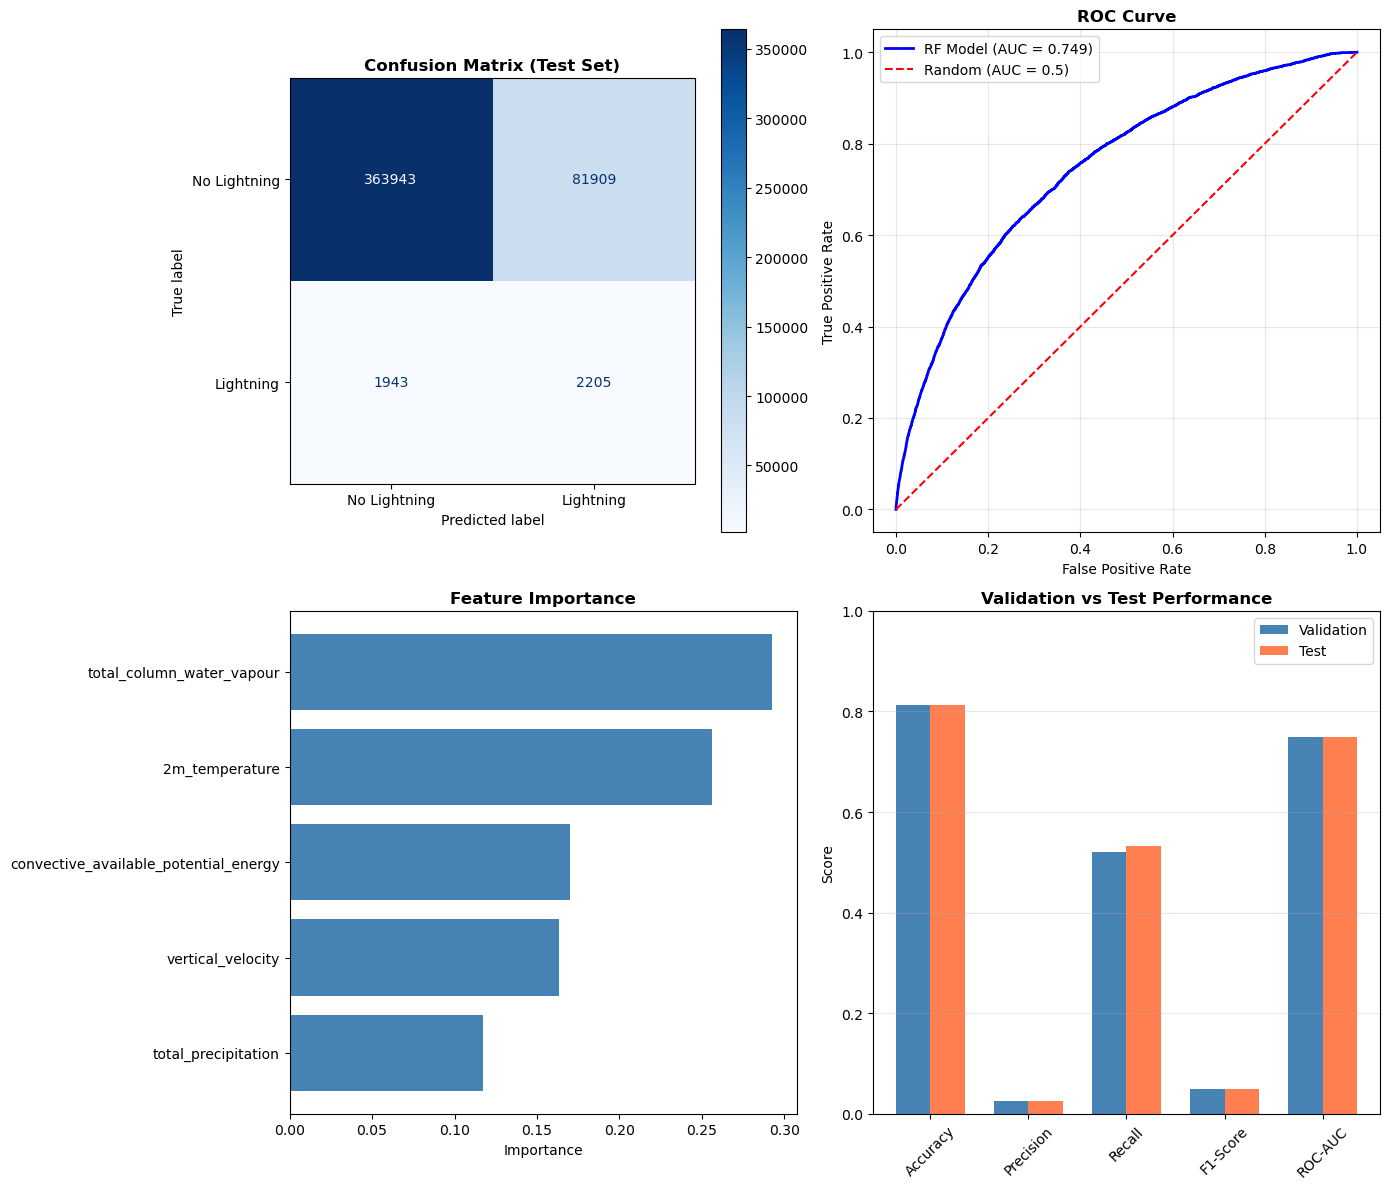


✓ Figure saved: rf_classification_results.png

BALANCED REGRESSION (Lightning Density)
Balanced dataset: 55,144
  Lightning: 27,572
  No lightning: 27,572

Training regressor...
Done!

=== VALIDATION ===
RMSE: 687.9487
MAE:  208.8699
R²:   -0.0366

=== TEST ===
RMSE: 535.3315
MAE:  198.4035
R²:   -0.0551

PREDICTION MAP - LAST HOUR
Last hour: 2024-07-31 23:00:00


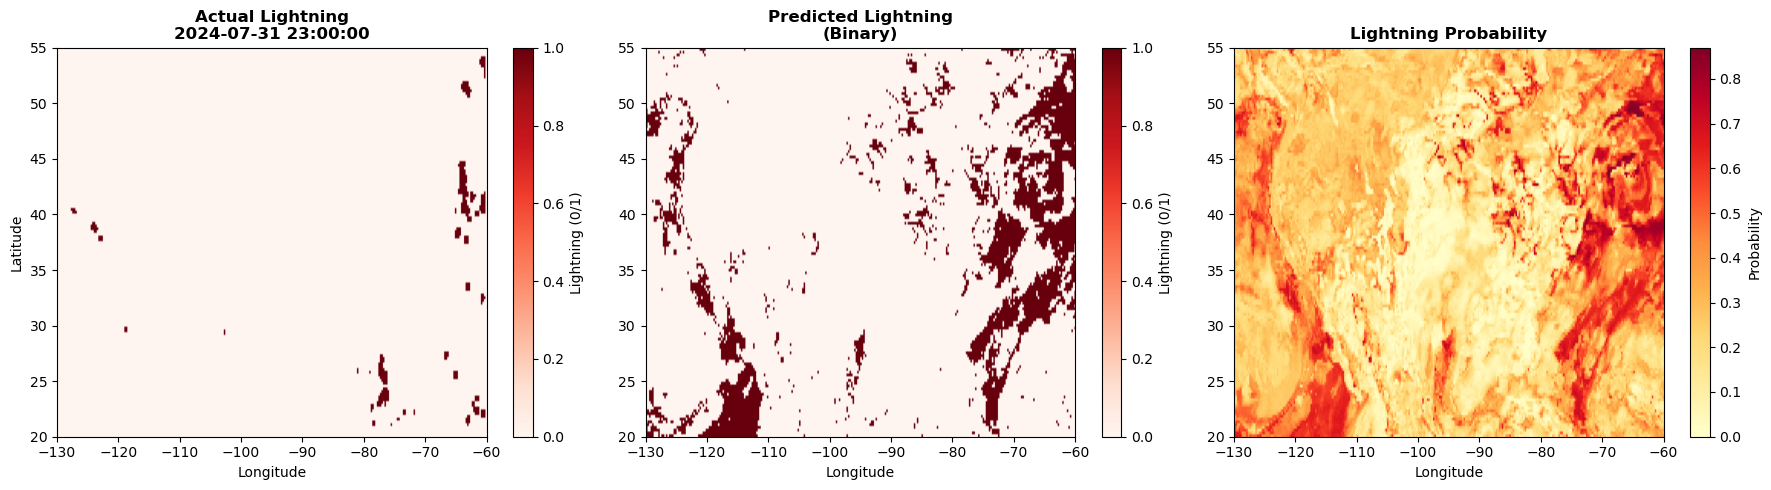


✓ Figure saved: rf_prediction_map.png

SUMMARY FOR PPT

CLASSIFICATION (Lightning Yes/No):
  • ROC-AUC:   0.749
  • Recall:    53.2%
  • Precision: 2.6%

REGRESSION (Lightning Density):
  • R²:   -0.055
  • RMSE: 535.33
  • MAE:  198.40

Top Features:
  1. Total column water vapour
  2. 2m temperature  
  3. CAPE
  4. Vertical velocity
  5. Total precipitation

COMPLETE!


In [2]:
# =============================================================
# COMPLETE RANDOM FOREST - LIGHTNING PREDICTION
# =============================================================

# =============================================================
# 1. LIBRARIES
# =============================================================
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (classification_report, confusion_matrix, 
                             ConfusionMatrixDisplay, accuracy_score,
                             precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, auc,
                             mean_squared_error, mean_absolute_error, r2_score)

print("Libraries loaded!")

# =============================================================
# 2. LOAD DATA
# =============================================================
print("\nLoading data...")
ds = xr.open_dataset('lightning_era5_merged_july2024.nc')
print(ds)

# =============================================================
# 3. CONVERT TO DATAFRAME
# =============================================================
print("\nConverting to DataFrame... (5-10 min)")
df = ds.to_dataframe().reset_index()
print(f"Shape: {df.shape}")
print(df.head())

# =============================================================
# 4. DEFINE FEATURES
# =============================================================
features = ['convective_available_potential_energy',
            'total_precipitation',
            '2m_temperature',
            'total_column_water_vapour',
            'vertical_velocity']

print(f"\nFeatures: {features}")

# =============================================================
# 5. SAMPLE DATA (3 million rows - avoids memory crash)
# =============================================================
df_sample = df.sample(n=3_000_000, random_state=42)
print(f"\nSampled: {len(df_sample):,} rows")

# =============================================================
# 6. PREPARE X AND Y (CLASSIFICATION - Binary)
# =============================================================
X = df_sample[features]
Y = (df_sample['lightning_density'] > 0).astype(int)

print(f"\nClass distribution:")
print(f"  No lightning (0): {(Y == 0).sum():,} ({(Y == 0).mean()*100:.1f}%)")
print(f"  Lightning (1):    {(Y == 1).sum():,} ({(Y == 1).mean()*100:.1f}%)")

# =============================================================
# 7. SPLIT: 70% TRAIN, 15% VALIDATION, 15% TEST
# =============================================================
X_temp, X_test, Y_temp, Y_test = train_test_split(
    X, Y, test_size=0.15, random_state=42
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_temp, Y_temp, test_size=0.176, random_state=42
)

print(f"\nData splits:")
print(f"  Train:      {len(X_train):,} (70%)")
print(f"  Validation: {len(X_val):,} (15%)")
print(f"  Test:       {len(X_test):,} (15%)")

# Verify lightning in all splits
print(f"\nLightning in each split:")
print(f"  Train:      {Y_train.sum():,}")
print(f"  Validation: {Y_val.sum():,}")
print(f"  Test:       {Y_test.sum():,}")

# =============================================================
# 8. TRAIN RANDOM FOREST CLASSIFIER
# =============================================================
rf_classifier = RandomForestClassifier(
    n_estimators=100,      # 100 trees (optimal from learning curve)
    max_depth=15,          # prevent overfitting
    class_weight='balanced', # handle imbalanced data
    random_state=42,
    n_jobs=-1              # use all CPU cores
)

print("\n" + "="*50)
print("TRAINING CLASSIFIER...")
print("="*50)
rf_classifier.fit(X_train, Y_train)
print("Done!")

# =============================================================
# 9. EVALUATE ON VALIDATION SET
# =============================================================
Y_val_pred = rf_classifier.predict(X_val)
Y_val_prob = rf_classifier.predict_proba(X_val)[:, 1]

print("\n" + "="*50)
print("VALIDATION RESULTS")
print("="*50)
print(f"Accuracy:  {accuracy_score(Y_val, Y_val_pred):.4f}")
print(f"Precision: {precision_score(Y_val, Y_val_pred):.4f}")
print(f"Recall:    {recall_score(Y_val, Y_val_pred):.4f}")
print(f"F1-Score:  {f1_score(Y_val, Y_val_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(Y_val, Y_val_prob):.4f}")

# =============================================================
# 10. EVALUATE ON TEST SET (FINAL)
# =============================================================
Y_test_pred = rf_classifier.predict(X_test)
Y_test_prob = rf_classifier.predict_proba(X_test)[:, 1]

print("\n" + "="*50)
print("TEST RESULTS (FINAL)")
print("="*50)
print(f"Accuracy:  {accuracy_score(Y_test, Y_test_pred):.4f}")
print(f"Precision: {precision_score(Y_test, Y_test_pred):.4f}")
print(f"Recall:    {recall_score(Y_test, Y_test_pred):.4f}")
print(f"F1-Score:  {f1_score(Y_test, Y_test_pred):.4f}")
print(f"ROC-AUC:   {roc_auc_score(Y_test, Y_test_prob):.4f}")

print("\nClassification Report:")
print(classification_report(Y_test, Y_test_pred, target_names=['No Lightning', 'Lightning']))

# =============================================================
# 11. FEATURE IMPORTANCE
# =============================================================
importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*50)
print("FEATURE IMPORTANCE")
print("="*50)
print(importance.to_string(index=False))

# =============================================================
# 12. PLOTS
# =============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    Y_test, Y_test_pred,
    display_labels=['No Lightning', 'Lightning'],
    cmap='Blues', ax=axes[0, 0]
)
axes[0, 0].set_title('Confusion Matrix (Test Set)', fontweight='bold')

# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(Y_test, Y_test_prob)
roc_auc = auc(fpr, tpr)
axes[0, 1].plot(fpr, tpr, 'b-', linewidth=2, label=f'RF Model (AUC = {roc_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'r--', label='Random (AUC = 0.5)')
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Feature Importance
axes[1, 0].barh(importance['Feature'], importance['Importance'], color='steelblue')
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Feature Importance', fontweight='bold')
axes[1, 0].invert_yaxis()

# Plot 4: Validation vs Test comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
val_scores = [
    accuracy_score(Y_val, Y_val_pred),
    precision_score(Y_val, Y_val_pred),
    recall_score(Y_val, Y_val_pred),
    f1_score(Y_val, Y_val_pred),
    roc_auc_score(Y_val, Y_val_prob)
]
test_scores = [
    accuracy_score(Y_test, Y_test_pred),
    precision_score(Y_test, Y_test_pred),
    recall_score(Y_test, Y_test_pred),
    f1_score(Y_test, Y_test_pred),
    roc_auc_score(Y_test, Y_test_prob)
]

x = np.arange(len(metrics))
width = 0.35
axes[1, 1].bar(x - width/2, val_scores, width, label='Validation', color='steelblue')
axes[1, 1].bar(x + width/2, test_scores, width, label='Test', color='coral')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Validation vs Test Performance', fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics, rotation=45)
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('rf_classification_results.png', dpi=150)
plt.show()

print("\n✓ Figure saved: rf_classification_results.png")

# =============================================================
# 13. BALANCED REGRESSION (Density prediction)
# =============================================================
print("\n" + "="*50)
print("BALANCED REGRESSION (Lightning Density)")
print("="*50)

# Balance data
df_lightning = df_sample[df_sample['lightning_density'] > 0]
df_no_lightning = df_sample[df_sample['lightning_density'] == 0]

n_lightning = len(df_lightning)
df_no_lightning_balanced = df_no_lightning.sample(n=n_lightning, random_state=42)

df_balanced = pd.concat([df_lightning, df_no_lightning_balanced]).sample(frac=1, random_state=42)

print(f"Balanced dataset: {len(df_balanced):,}")
print(f"  Lightning: {len(df_lightning):,}")
print(f"  No lightning: {len(df_no_lightning_balanced):,}")

# Prepare
X_bal = df_balanced[features]
Y_bal = df_balanced['lightning_density']

# Split
X_temp_r, X_test_r, Y_temp_r, Y_test_r = train_test_split(X_bal, Y_bal, test_size=0.15, random_state=42)
X_train_r, X_val_r, Y_train_r, Y_val_r = train_test_split(X_temp_r, Y_temp_r, test_size=0.176, random_state=42)

# Train
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)

print("\nTraining regressor...")
rf_regressor.fit(X_train_r, Y_train_r)
print("Done!")

# Evaluate
Y_val_pred_r = rf_regressor.predict(X_val_r)
Y_test_pred_r = rf_regressor.predict(X_test_r)

print("\n=== VALIDATION ===")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_val_r, Y_val_pred_r)):.4f}")
print(f"MAE:  {mean_absolute_error(Y_val_r, Y_val_pred_r):.4f}")
print(f"R²:   {r2_score(Y_val_r, Y_val_pred_r):.4f}")

print("\n=== TEST ===")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_test_r, Y_test_pred_r)):.4f}")
print(f"MAE:  {mean_absolute_error(Y_test_r, Y_test_pred_r):.4f}")
print(f"R²:   {r2_score(Y_test_r, Y_test_pred_r):.4f}")

# =============================================================
# 14. PREDICTION MAP (Last Hour)
# =============================================================
print("\n" + "="*50)
print("PREDICTION MAP - LAST HOUR")
print("="*50)

last_hour = df['time'].max()
print(f"Last hour: {last_hour}")

df_last = df[df['time'] == last_hour].copy()
X_last = df_last[features]

df_last['pred_binary'] = rf_classifier.predict(X_last)
df_last['pred_prob'] = rf_classifier.predict_proba(X_last)[:, 1]
df_last['actual'] = (df_last['lightning_density'] > 0).astype(int)

# Plot maps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

actual_map = df_last.pivot(index='latitude', columns='longitude', values='actual')
pred_map = df_last.pivot(index='latitude', columns='longitude', values='pred_binary')
prob_map = df_last.pivot(index='latitude', columns='longitude', values='pred_prob')

lons = df_last['longitude'].unique()
lats = df_last['latitude'].unique()

im1 = axes[0].imshow(actual_map, cmap='Reds', aspect='auto', origin='lower',
                      extent=[lons.min(), lons.max(), lats.min(), lats.max()])
axes[0].set_title(f'Actual Lightning\n{last_hour}', fontweight='bold')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
plt.colorbar(im1, ax=axes[0], label='Lightning (0/1)')

im2 = axes[1].imshow(pred_map, cmap='Reds', aspect='auto', origin='lower',
                      extent=[lons.min(), lons.max(), lats.min(), lats.max()])
axes[1].set_title('Predicted Lightning\n(Binary)', fontweight='bold')
axes[1].set_xlabel('Longitude')
plt.colorbar(im2, ax=axes[1], label='Lightning (0/1)')

im3 = axes[2].imshow(prob_map, cmap='YlOrRd', aspect='auto', origin='lower',
                      extent=[lons.min(), lons.max(), lats.min(), lats.max()])
axes[2].set_title('Lightning Probability', fontweight='bold')
axes[2].set_xlabel('Longitude')
plt.colorbar(im3, ax=axes[2], label='Probability')

plt.tight_layout()
plt.savefig('rf_prediction_map.png', dpi=150)
plt.show()

print("\n✓ Figure saved: rf_prediction_map.png")

# =============================================================
# 15. SUMMARY
# =============================================================
print("\n" + "="*50)
print("SUMMARY FOR PPT")
print("="*50)
print("""
CLASSIFICATION (Lightning Yes/No):
  • ROC-AUC:   {:.3f}
  • Recall:    {:.1f}%
  • Precision: {:.1f}%

REGRESSION (Lightning Density):
  • R²:   {:.3f}
  • RMSE: {:.2f}
  • MAE:  {:.2f}

Top Features:
  1. Total column water vapour
  2. 2m temperature  
  3. CAPE
  4. Vertical velocity
  5. Total precipitation
""".format(
    roc_auc_score(Y_test, Y_test_prob),
    recall_score(Y_test, Y_test_pred) * 100,
    precision_score(Y_test, Y_test_pred) * 100,
    r2_score(Y_test_r, Y_test_pred_r),
    np.sqrt(mean_squared_error(Y_test_r, Y_test_pred_r)),
    mean_absolute_error(Y_test_r, Y_test_pred_r)
))

print("="*50)
print("COMPLETE!")
print("="*50)